# AlexNet

### About

1. This project has been tested under Ubuntu18.04
2. Dataset: https://www.kaggle.com/slothkong/10-monkey-species

### Environment

* PyTorch 0.4.0
* CUDA 9.1, v9.1.85
* cuDNN v7.1.2 (Mar 21, 2018), for CUDA 9.1 & 9.2 without any patch

### Application

* Please check out the release: https://github.com/forrestning/AlexNet/releases

In [1]:
""" Set devices """
GPU = True

""" Set data """
SHUFFLE = True
BATCH_SIZE = 48
NUM_WORKERS = 16

""" Set training """
LR = 1e-2
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005
EPOCH = 800
loss_boundary = (1.0, 0.2, 0.05, -1)

""" Set testing """
IN_DATA_FREQ = 20
OUT_DATA_FREQ = 10

### Imports
Import some necessety libs

In [2]:
import torch
from torch import nn, device
from torchvision import datasets
import torchvision.transforms as tf
from torch.utils.data import DataLoader
from collections import OrderedDict
from PIL import Image
import matplotlib.pyplot as plt
from time import time

%matplotlib inline

### Config Device

To use GPU, assume that we are o a CUDA machine,
that this should print a CUDA device;
else should print 'cpu'.

In [3]:
devices = device(
    'cuda:0' if (torch.cuda.is_available() and GPU)
    else 'cpu')

print(
    '\n', 3 * '*',
    ' This calculation takes place in {}'.format(devices),
          3 * '*', '\n')


 ***  This calculation takes place in cuda:0 *** 



### Setting and Loading Data set
transform:
1. Resize the image to 256*256
2. Crop the given PIL Image to random size and aspect ratio.
3. Jittering images.
4. Horizontally flip the given PIL Image randomly 
   with a given probability.
5. Convert a PIL Image to tensor.
6. Normalized image with MAGIC number
    * mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225).
    * about the MAGIC number: 
        https://discuss.pytorch.org/t/whats-the-range-of-the-input-value-desired-to-use-pretrained-resnet152-and-vgg19/1683/6

train_set:
1. Set root path of data.
2. Set data transformation.

test_set:
1. Set root path of data.
2. Set data transformation.

train_loader:
1. Set data to load.
2. Set batch size.
3. Weather to shuffle data.
4. Set numbers of workers.

test_loader:
1. Set data to load.
2. Set batch size.
3. Weather to shuffle data.
4. Set numbers of workers.

In [4]:
transform = tf.Compose([
    tf.Resize(256),
    tf.RandomResizedCrop(227),
    tf.ColorJitter(
        brightness=0.1, 
        contrast=0.1, 
        saturation=0.1, 
        hue=0.1),
    tf.RandomHorizontalFlip(0.5),
    tf.ToTensor(),
    tf.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_set = datasets.ImageFolder(
    root='./monkey/training',
    transform=transform,
)

test_set = datasets.ImageFolder(
    root='./monkey/validation',
    transform=transform,
)

train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE,
    num_workers=NUM_WORKERS,
)

test_loader = DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE,
    num_workers=NUM_WORKERS,
)

print(
    'About this data set:\n',
    'There are {} data in training set.\n'.format(len(train_set)),
    'There are {} data in testing set.\n'.format(len(test_set)))

About this data set:
 There are 1097 data in training set.
 There are 272 data in testing set.



### Print an image just for fun XD~~

We can seee that the size of images in the set are various.

Therefore, it is necessary to resize before training.

Monkey No. 100 in Training set ~~



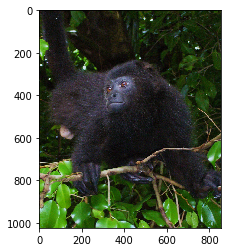

In [5]:
def show_monkey(which_one, set_):
    print('Monkey No. {} in Training set ~~\n'.format(which_one))
    im = Image.open(set_.imgs[which_one][0])
    plt.imshow(im)
    plt.show()
    
show_monkey(100, train_set)

### AlexNet

In [6]:
class AlexNet(nn.Module):

    def __init__(self):
        super(AlexNet, self).__init__()

        # 32, 3, 227, 227
        self.c1 = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(
                in_channels=3,
                out_channels=96,
                kernel_size=11,
                stride=4,
            )),
            # [(227-11)/4]+1 = 55
            # 32, 96, 55, 55
            ('ReLU', nn.ReLU(inplace=True)),
            ('s1', nn.MaxPool2d(
                kernel_size=3,
                stride=2,
            )),
            # [(55-3)/2]+1 = 27
            # 32, 96, 27, 27
            ('LRN1', nn.LocalResponseNorm(
                5, 
                alpha=1e-4, 
                beta=0.75, 
                k=2
            )),
        ]))

        self.c2 = nn.Sequential(OrderedDict([
            # 32, 96, 27, 27
            ('c2', nn.Conv2d(
                in_channels=96,
                out_channels=256,
                kernel_size=5,
                padding=2,
            )),
            # [(27+2+2)-5]+1 = 27
            # 32, 256, 27, 27
            ('ReLU', nn.ReLU(inplace=True)),
            ('s2', nn.MaxPool2d(
                kernel_size=3,
                stride=2,
            )),
            # [(27-3)/2]+1 = 13
            # 32, 256, 13, 13
            ('LRN2', nn.LocalResponseNorm(
                5, 
                alpha=1e-4, 
                beta=0.75, 
                k=2
            )),
        ]))

        self.c3 = nn.Sequential(OrderedDict([
            # 32, 256, 13, 13
            ('c3', nn.Conv2d(
                in_channels=256,
                out_channels=384,
                padding=1,
                kernel_size=3,
            )),
            # (13+1+1)-3+1 = 13
            # 32, 384, 13, 13
            ('ReLU', nn.ReLU(inplace=True)),
        ]))

        self.c4 = nn.Sequential(OrderedDict([
            # 32, 384, 13, 13
            ('c4', nn.Conv2d(
                in_channels=384,
                out_channels=384,
                kernel_size=3,
                padding=1,
            )),
            # (13+1+1)-3+1 = 13
            # 32, 384, 13, 13
            ('ReLU', nn.ReLU(inplace=True))
        ]))

        self.c5 = nn.Sequential(OrderedDict([
            # 32, 384, 13, 13
            ('c5', nn.Conv2d(
                in_channels=384,
                out_channels=256,
                kernel_size=3,
                padding=1,
            )),
            # (13+1+1)-3+1 = 13
            # 32, 256, 13, 13
            ('ReLU', nn.ReLU(inplace=True)),
            ('s5', nn.MaxPool2d(
                kernel_size=3,
                stride=2,
            )),
            # [(13-3)/2]+1
            # 32, 256, 6, 6
        ]))

        self.fc1 = nn.Sequential(OrderedDict([
            ('l1', nn.Linear(
                in_features=6 * 6 * 256,
                out_features=4096,
            )),
            ('ReLU', nn.ReLU(inplace=True)),
            ('drop', nn.Dropout(0.5)),
        ]))

        self.fc2 = nn.Sequential(OrderedDict([
            ('l2', nn.Linear(
                in_features=4096,
                out_features=4096,
            )),
            ('ReLU', nn.ReLU(inplace=True)),
            ('drop', nn.Dropout(0.5)),
        ]))

        self.fc3 = nn.Sequential(OrderedDict([
            ('l3', nn.Linear(
                in_features=4096,
                out_features=10,
            )),
        ]))

    def forward(self, x):
        x = self.c5(self.c4(self.c3(self.c2(self.c1(x)))))
        x = x.view(x.size(0), -1)
        x = self.fc3(self.fc2(self.fc1(x)))

        return x

### Training and Testing
1. Setting Net.
2. Setting Loss Function.
3. Setting Optimizer.

In [7]:
net = AlexNet().to(devices)

loss_func = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    net.parameters(),
    lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

print(net)

AlexNet(
  (c1): Sequential(
    (c1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (ReLU): ReLU(inplace)
    (s1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (LRN1): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
  )
  (c2): Sequential(
    (c2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (ReLU): ReLU(inplace)
    (s2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (LRN2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
  )
  (c3): Sequential(
    (c3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (ReLU): ReLU(inplace)
  )
  (c4): Sequential(
    (c4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (ReLU): ReLU(inplace)
  )
  (c5): Sequential(
    (c5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (ReLU): ReLU(inplace)
    (s5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode

Start Training ~~~ >_<


<IPython.core.display.Javascript object>


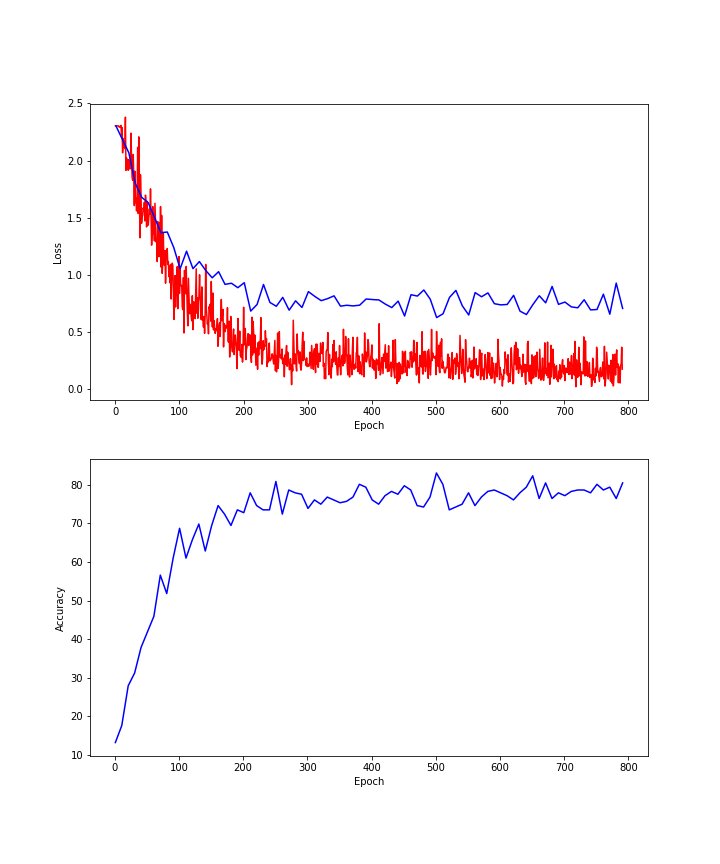

Epoch: 67, Loss: 0.9887495040893555, 
Now, Change LR to 0.005

Epoch: 179, Loss: 0.16213832795619965, 
Now, Change LR to 0.0025

Epoch: 235, Loss: 0.04975295066833496, 
Now, Change LR to 0.00125

Finished Training ~~~ ^_^
 It coust 10889.38 sec


<IPython.core.display.Javascript object>


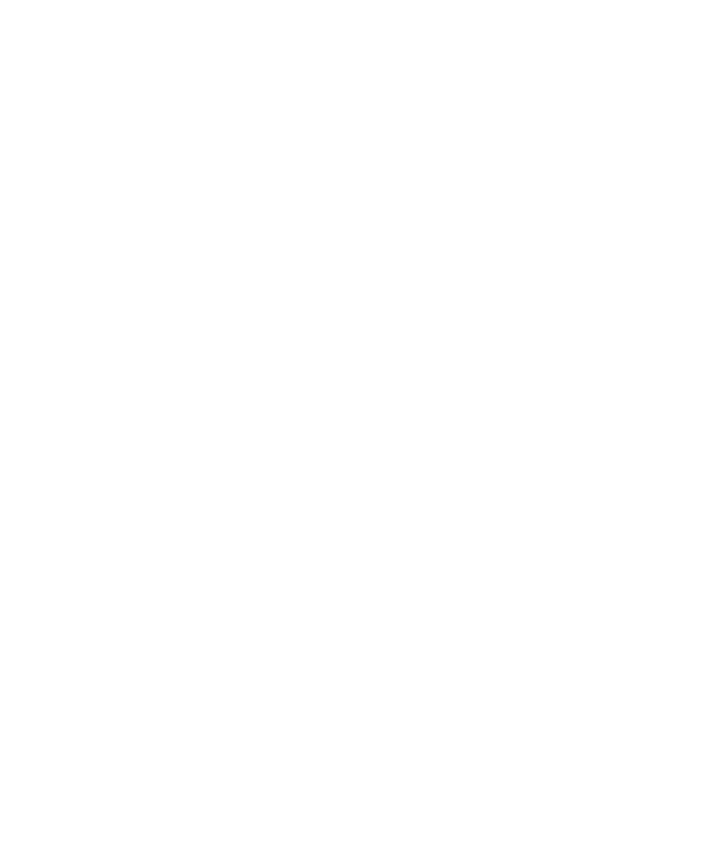

In [8]:
print('Start Training ~~~ >_<')

% matplotlib notebook
plt.ion()
fig = plt.figure(1, figsize=(10, 12))

train_loss_x, train_loss_y = [], []
test_loss_x, test_loss_y = [], []
train_accuracy_x, train_accuracy_y = [], []
test_accuracy_x, test_accuracy_y = [], []

time_0 = time()
boundart_i = 0
iter_ = 0
for epoch in range(EPOCH):
    for i, data_ in enumerate(train_loader):
        
        """ load data """
        images, labels = data_
        images, labels = images.to(devices), labels.to(devices)

        """ initialize optimizer """
        optimizer.zero_grad()

        """ get output from net """
        output = net(images)

        """ calculate loss """
        loss = loss_func(output, labels)
        loss.backward()
        loss = loss.item()
        
        """ slow down learning rate """
        if loss < loss_boundary[boundart_i]:
            boundart_i += 1
            
            LR /= 2
            print('Epoch: {}, Loss: {}, \nNow, Change LR to {}\n'.format(
                epoch, loss, LR))
            
            optimizer = torch.optim.SGD(
                net.parameters(),
                lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

        """ optimizer """
        optimizer.step()

        """ in-data """
        if iter_ % IN_DATA_FREQ == 0:
            train_loss_x.append(epoch+i*BATCH_SIZE/len(train_set))
            train_loss_y.append(loss)
            """
            print('Epoch: {}. Trained data: {}. Loss: {}.'.format(
                epoch, i * BATCH_SIZE, loss))
            """

        iter_ += 1

    """ out data """
    if epoch % OUT_DATA_FREQ == 0 or epoch == EPOCH:

        test_loss = 0.0
        counter = 0.0

        total = 0
        correct = 0

        for i, data_ in enumerate(test_loader):
            """ load data """
            images, labels = data_
            images, labels = images.to(devices), labels.to(devices)

            """ get output from net """
            output = net(images)

            """ accumulate loss """
            test_loss += loss_func(output, labels).item()

            """ get predictions """
            prediction_prob, prediction = torch.max(output, 1)
            labels = labels.cpu().numpy()
            prediction = prediction.cpu().numpy()

            """ calculate total accuracy """
            total += len(labels)
            for j, t_l in enumerate(labels):
                if t_l == prediction[j]:
                    correct += 1
            counter += 1

        """ append data into arrays """
        test_loss_x.append(epoch+1)
        test_loss_y.append(test_loss/counter)
        test_accuracy_x.append(epoch+1)
        test_accuracy_y.append(100 * correct / total)
        """
        print('Out-Data Test:\n',
              'Epoch: {}. Test data: {}.\n Loss: {}. Accuracy: {}\n'.format(
                  epoch, len(test_set),
                  test_loss / counter,
                  100 * correct / total))
        """
        
        """ data visualization """
        fig.clear()
        ax = plt.subplot(211)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.plot(train_loss_x, train_loss_y, 'r-')
        ax.plot(test_loss_x, test_loss_y, 'b-')

        ax1 = plt.subplot(212)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.plot(test_accuracy_x, test_accuracy_y, 'b-')
        fig.canvas.draw()

time_1 = time()
print(
    'Finished Training ~~~ ^_^\n',
    'It coust {:.2f} sec'.format(time_1 - time_0))


torch.save(net.state_dict(), 'APP/alex_net.pkl')